
# Metadata :
**CW2: Machine Learning Case Study**

- `Author` : Taisir Boukrouba
- `ID` : 22084758
- `Module` : Machine Learning & Neural Networks
- `Problem` : Regression
- `Data` : Medical Cost Personal Dataset



# I - Initialization

## Importing Libraries
First we import all of the needed libraries before staring to work on our data

In [71]:
import warnings
import zipfile
import os
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score,mean_squared_error,mean_absolute_error,r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

# supressing simple warning
warnings.simplefilter("ignore")

## Defining Functions
Here we have defined the most used functions where :
- `grid_search()` : Performs grid search to find the best hyperparameters for the given model
- `performance_table()` : Generates a performance table based on the results of grid search
- `top_5_perfromance_plot()` : Generates a line plot to visualize the performance of the top 5 models and returns scores of the top 10
- `predict_and_evaluate()` : Trains , predicts and evaluates the inputed model

In [72]:
def grid_search(model,param_grid,metric) :
    """
    Performs grid search to find the best hyperparameters for the given model.

    Parameters:
    - model (estimator): The machine learning model to be tuned.
    - param_grid (dict): Dictionary containing the hyperparameter values to search over.
    - metric (str or callable): The scoring metric to be used for evaluation.

    Returns:
    - grid_search (GridSearchCV): The GridSearchCV object containing the results of the grid search.
    - best_model (estimator): The best estimator obtained from the grid search.
    """

    # Creating the GridSearchCV object
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5 , scoring=metric)
    # Training the model with grid search
    grid_search.fit(X_train, y_train)
    # Getting the best model and best parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    # Printing the best parameters
    print(f" Best parameters are : {best_params} ")
    return grid_search,best_model

In [73]:
def performance_table(grid_search) :
    """
    Generate a performance table based on the results of grid search.

    Parameters:
    - grid_search (GridSearchCV): The GridSearchCV object containing the results of the grid search.

    Returns:
    - results (DataFrame): DataFrame containing the detailed results of the grid search.
    - top10 (DataFrame): DataFrame containing the top 10 models based on test scores.
    """

    results = pd.DataFrame(grid_search.cv_results_)
    results = results.sort_values(by=["rank_test_score"])
    results = results.set_index(
        results["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
    ).rename_axis("kernel")
    top10 = results[["params", "rank_test_score", "mean_test_score", "std_test_score"]][:10]

    return results,top10

In [74]:
def top5_performance_plot(results,xlabel,ylabel,title):
    """
    Generate a line plot to visualize the performance of the top 5 models and returns scores of the top 10.

    Parameters:
    - results (DataFrame): DataFrame containing the detailed results of the grid search.
    - xlabel (str): Label for the x-axis.
    - ylabel (str): Label for the y-axis.
    - title (str): Title for the plot.

    Returns:
    - Plots a line plot of top 5 performing models
    - model_scores (DataFrame): DataFrame containing the scores of the top 10 models.
    """

    # create df of model scores ordered by performance
    model_scores = results.filter(regex=r"split\d*_test_score")[:10]
    fig, ax = plt.subplots(figsize=(20,8))
    sns.lineplot(
        data=model_scores[:5].transpose(),
        dashes=False,
        marker="o",
        alpha=0.5,
        ax=ax)

    ax.set_xlabel(xlabel, size=12, labelpad=10)
    ax.set_ylabel(ylabel, size=12)
    ax.tick_params(bottom=True, labelbottom=False)
    ax.set_title(title)

    return model_scores

In [75]:
def predict_and_evaluate(best_model,X_train,y_train,X_test,y_test):
    """
    Calculate regression metrics including Mean Absolute Error, Mean Squared Error,
    Root Mean Squared Error, and R squared score.

    Parameters:
    - best_model (estimator): The best estimator obtained from the grid search.

    Returns:
    None
    """

    best_model.fit(X_train,y_train)
    y_pred = best_model.predict(X_test)
    mae = mean_absolute_error(y_test,np.exp(y_pred))
    mse = mean_squared_error(y_test,np.exp(y_pred))
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, np.exp(y_pred))

    print("The Mean Absolute Error is :",round(mae,2))
    print("The Mean Square Error is  :",round(mse,2))
    print("The Root Mean Square Error is : :",round(rmse,2))
    print("The R squared score is :",round(r2,2))

# II - Data Loading
In this step we try to get our data from kaggle website using the github repository's JSON file and then we do some general info reading of our dataframe

- This dataset in question as we mintionned is brought from [kaggle](https://www.kaggle.com/datasets/mirichoi0218/insurance) and called Medical Cost Personal Datasets which has insurer information which might help us predict the insurance cost in the US



##  Getting Data :
Here from the github repository we're getting the kaggle `json` file which contrains username and API code used to get the dataset from the kaggle website

In [76]:
file_url = 'https://github.com/stardustyangel/Medical-Insurance-Cost-Regression-Analysis/raw/main/kaggle.json'

# Download the file from the URL
response = requests.get(file_url)
file_content = response.content

# Save the content to a file in the /content/ directory
file_path = '/content/kaggle.json'
with open(file_path, 'wb') as file:
    file.write(file_content)

# Move the file to the appropriate location
!mkdir -p ~/.kaggle
!mv /content/kaggle.json ~/.kaggle/

# Set appropriate permissions
!chmod 600 ~/.kaggle/kaggle.json

# Verify that the file is successfully moved
print("File moved to:", '/root/.kaggle/kaggle.json')

!kaggle datasets download -d mirichoi0218/insurance

File moved to: /root/.kaggle/kaggle.json
insurance.zip: Skipping, found more recently modified local copy (use --force to force download)


In [77]:
#Extracting data
zip_path = '/content/insurance.zip'
extract_path = '/kaggle/working/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List the contents of the extracted directory
extracted_contents = os.listdir(extract_path)
print(extracted_contents)

['insurance.csv']


## Reading data :
Here we read the downloaded csv file as a dataframe and we do first step exploration to know some general information about the data

In [78]:
df = pd.read_csv("/kaggle/working/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [80]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


# III - Exploratory Data Analysis :
In this step we explore our dataframe thouroughly using different plots which should explain and give extra information about the various features of the medical cost dataset where :     
- **Univariate Analysis :** Focuses on summarizing and analyzing `one` variable at a time.
- **Bivariate Analysis:** Examines the relationship between `two` variables.
- **Multivariate Analysis:** Investigates the relationships and interactions among `three or more` variables.




##  1. Univariate Analysis :

In this plot , we can notice that Adults Aged 18-33 are the dominant section in terms of Age with 39% followed by Pre-retirment Aged 48-64 with About 31% and finally the Middle Aged between 33-48 with 30%

> Note that the `Age` column is represented as a continous variable in the dataframe , we have binned it just for EDA purposes

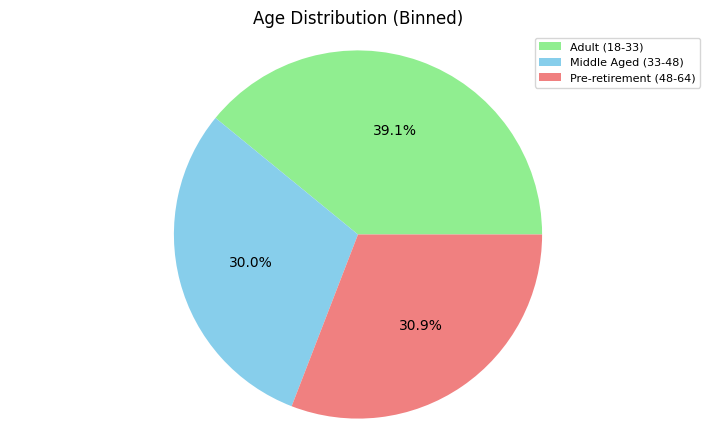

In [81]:
plt.figure(figsize=(8, 5))
age = round(df["age"])
bins = np.linspace(age.min(), age.max(), 4)
bin_labels = ["Adult (18-33)", "Middle Aged (33-48)", "Pre-retirement (48-64)"]

# Count data points in each bin (histogram)
counts, _ = np.histogram(age, bins=bins)
plt.style.use('default')
# Create pie chart with labels and colors (adjust colors as desired)
plt.pie(counts, autopct="%1.1f%%", startangle=0, colors=['lightgreen','skyblue','lightcoral'])
plt.legend(bin_labels,fontsize=8)
plt.axis('equal')
plt.title("Age Distribution (Binned)")
plt.show()

we can notice that our target variable `charges` has an upper extreme (max) of  about 35K USD but we found values that goes beyond that reaching about 64K USD (these were outliers). Applying the log transformation will help compress these large values into smaller ones reducing the gap between our normal values and the outliers and also get rid of the skewness of the distribution cause by them


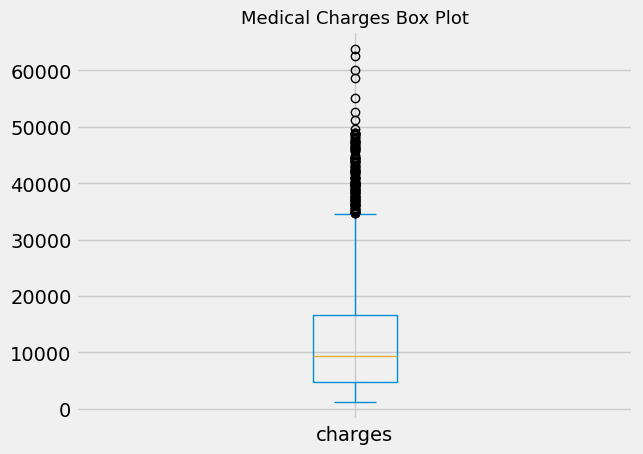

In [82]:
plt.style.use('fivethirtyeight')
df["charges"].plot(kind="box")
plt.title("Medical Charges Box Plot",fontsize=13);

Looking at the `BMI` distribution , it explains why there are many outlier `charges` where we can see that it's skewed towards the right + about 50% of the distribution is Obses

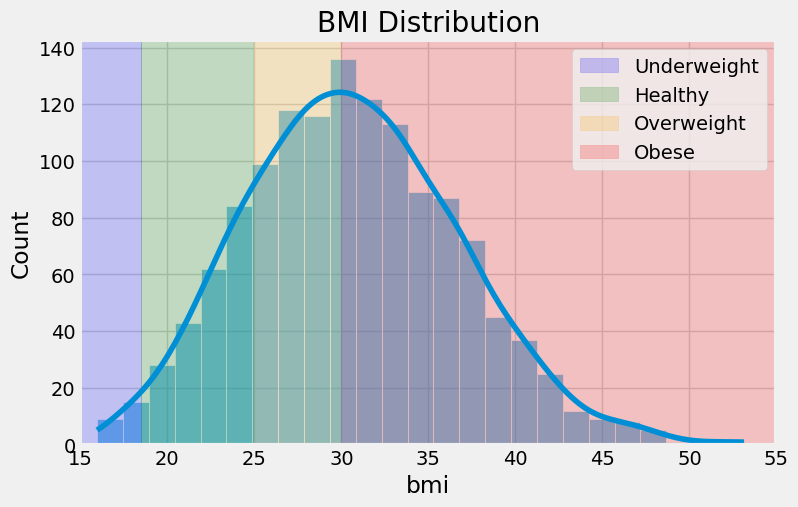

In [83]:
plt.figure(figsize=(8, 5))
sns.histplot(data=df,x="bmi",kde=True);
plt.axvspan(15, 18.5, color="blue", alpha=0.2,label="Underweight")
plt.axvspan(18.5, 24.9, color="green", alpha=0.2,label="Healthy")
plt.axvspan(25, 29.9, color="orange", alpha=0.2,label="Overweight")
plt.axvspan(30,55, color="red", alpha=0.2,label="Obese")
plt.title("BMI Distribution")
plt.xlim(15,55)
plt.legend();

## 2. Bivariate Analysis :

In this plot we can the different medical `charges` per `regions` where the southeast has the highest medical charges of about 64K\$ then the max gets lower for northwest with about 60K\$ , then < 60 K\$ in northeast and finally ~ 54K\$ in southwest

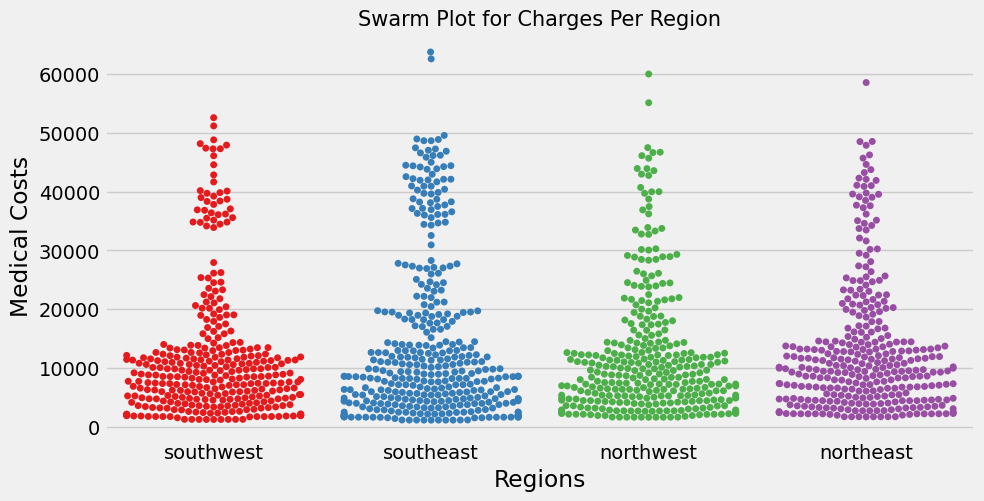

In [84]:
plt.figure(figsize=(10, 5))

# Using Seaborn to create a swarm plot
sns.swarmplot(x="region", y="charges", data=df, palette='Set1')

plt.title('Swarm Plot for Charges Per Region',fontsize=15)
plt.xlabel('Regions')
plt.ylabel('Medical Costs')
plt.yticks()
plt.show()

We can see that the we have bigger femal smoker/ femal non-smoker ration compared to male smoker/ male non-smoker while overall males are more prone to smoking according to the plot

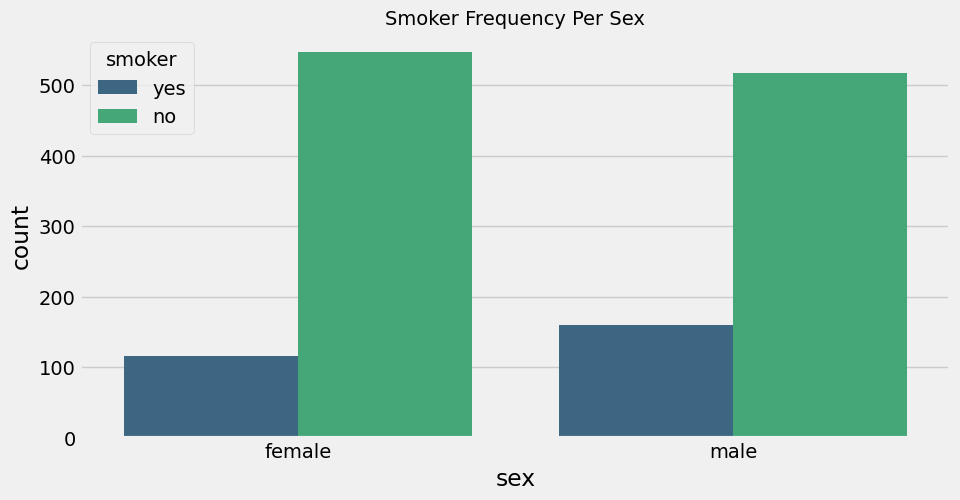

In [85]:
plt.figure(figsize=(10,5))
sns.countplot(data=df,x="sex",hue="smoker",palette="viridis")
plt.legend(labels=["yes","no"],title="smoker")
plt.title("Smoker Frequency Per Sex",fontsize=14);

We can see that the charges changes with the number of children but no linearly where 2-3 children are chraged more and this can be because there are more 2-3 children than 0-1 or 4-5 which totally makes sense ( this is accumulative charges not per child )

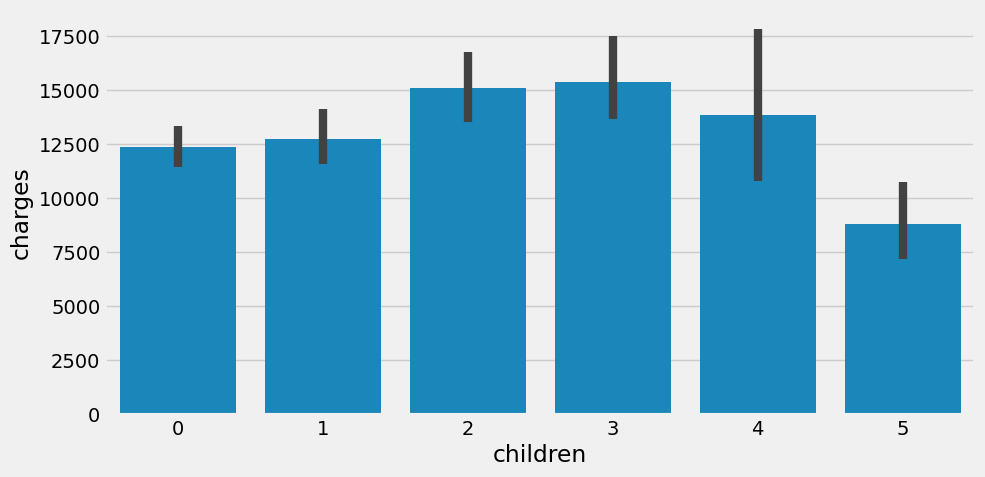

In [86]:
plt.figure(figsize=(10,5))
sns.barplot(data=df,x="children",y="charges");

## 3. Multivariate Analysis


This pair plot show the the distribution of each feature (diagonal) also the correlation between each feature and the other , where we can notice there isn't much correlation (nor positive or negative) and it's very low where the biggest one is noticed between `bmi` and `charges`

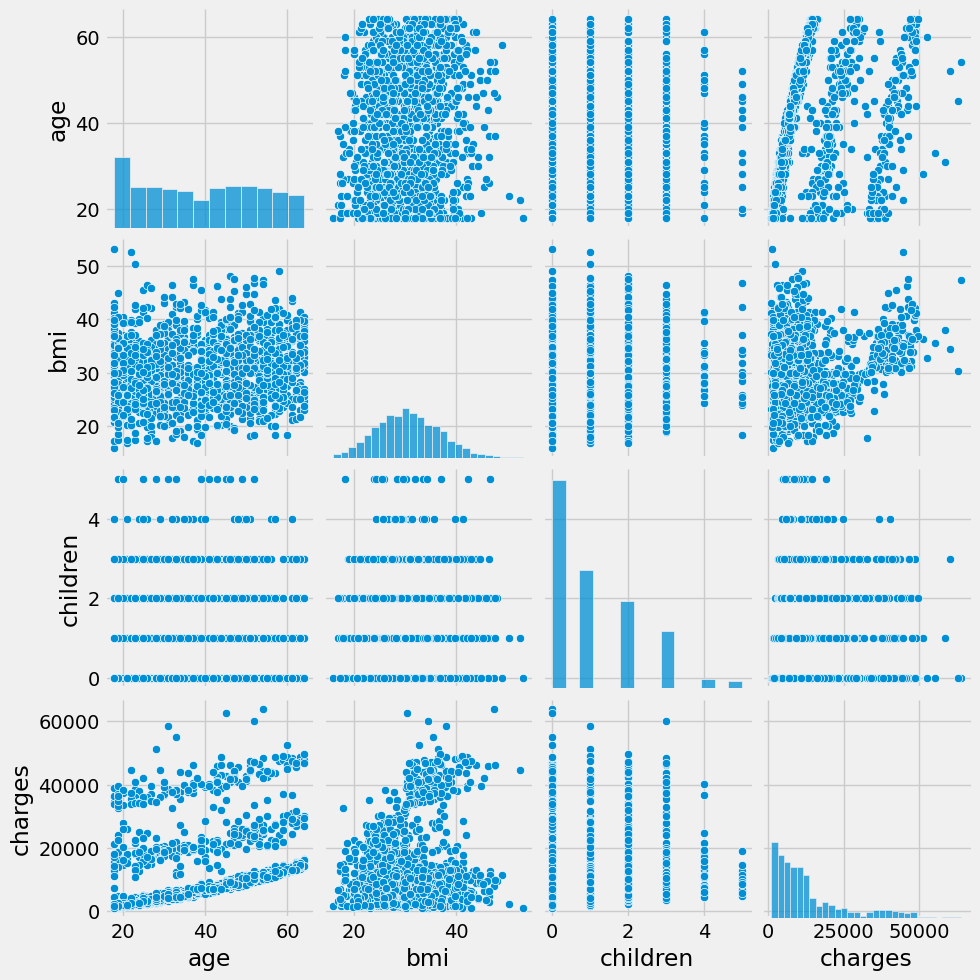

In [87]:
sns.pairplot(data=df);

# IV - Data Preprocessing :
In this step , we process (filter) our data to make it most suitable for the modelling phase

- **Data Cleaning :** Looking for missing values and cleaning them if found
- **Cardinality Check :** Looking for values with very high or very low cardinality which has no effect
- **Data Tranformation :** Transforming all the categorical object type values to numerical values using `Label Encoder`
- **Data Normalization :** Different columns are showing different value ranges which makes sence to scall them using `Standard Scaller`
- **Log Transformation :** Transforming the target variable using `log-transform` to get rid of outliers
- **Splitting data :** split data into training/testig using `train_test_split()`

## Null Check :
The data is clear of missing values which means there is no need for imputation or dropping missing values

In [88]:
# There is no null values so no need for imputation or dropping
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

## Cardinality Check
In this we look for values with very high (0.99) or very low (0.0) cardinality (uniqueness) only for categorical features (logical to have very high cardinaly with continous features)
> The categorical feature having about 100% or 0% cardinality means the model can't learn any patterns from the feature and it needs to be dropped (nothing to do here)

In [89]:
df.nunique()/df.shape[0]

age         0.035127
sex         0.001495
bmi         0.409567
children    0.004484
smoker      0.001495
region      0.002990
charges     0.999253
dtype: float64

## Data Transformation :
We have 2 categorical features which are Sex (Male/Female) and Smoker (Yes/No) and ML models can't directly understand and process text labels  like "Male", "Female", or "Yes", "No". They require numerical features to perform calculations and learn patterns.
> Also it’s unclear for distance-based algorithms (like SVM) to calculate distance when variables are not numerical.

In [90]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [91]:
cols = df.select_dtypes(include='object')

for col in cols :
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   int64  
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   int64  
 5   region    1338 non-null   int64  
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(5)
memory usage: 73.3 KB


## Log Transformation :
In this case we are testing log transformation on the totality of our target variables , but later we'll use the original and only apply log-transformation on the training data and back-transform with predicted values to get accurate real loss values

In [93]:
# applying log transformation on target variable
df["log_charges"] = np.log(df["charges"])

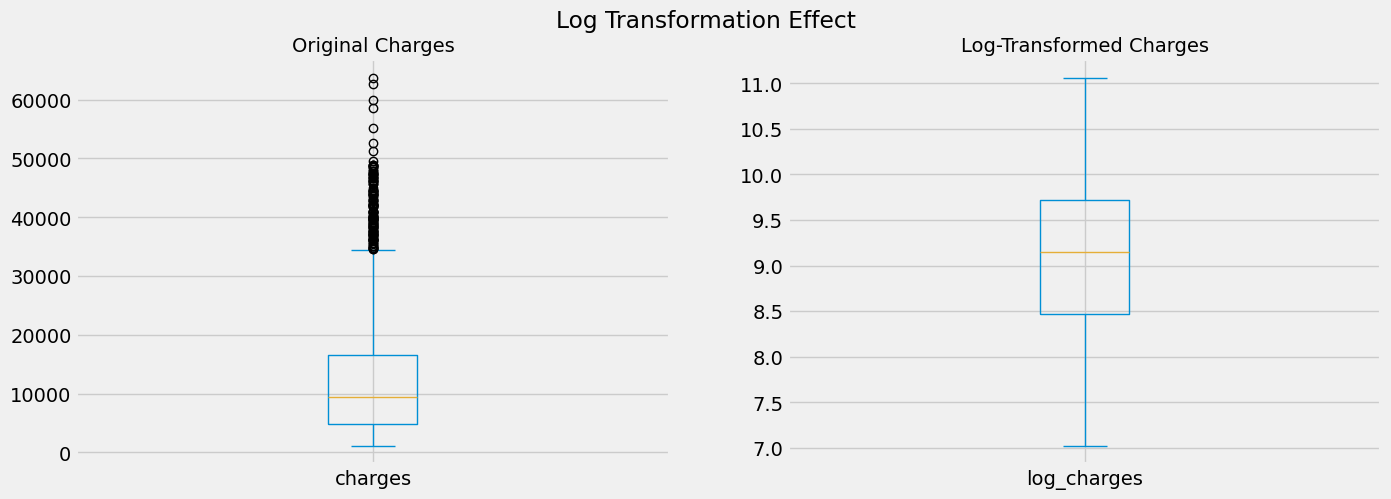

In [94]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
df["charges"].plot(kind="box");
plt.title("Original Charges",fontsize=14)
plt.subplot(1,2,2)
df["log_charges"].plot(kind="box");
plt.title("Log-Transformed Charges",fontsize=14)
plt.suptitle("Log Transformation Effect");

## Feature Selection :
Here we are looking through different correlation of feature to `charges` and `log-charges` to see if there is a feature worth dropping
> I decided to not drop any feature to because the correlation being small just means it's not linearly corelated but deosn't mean not correlated at all

In [95]:
(df.corr().charges*100).sort_values(ascending=False)

charges        100.000000
log_charges     89.296420
smoker          78.725143
age             29.900819
bmi             19.834097
children         6.799823
sex              5.729206
region          -0.620823
Name: charges, dtype: float64

In [96]:
(df.corr().log_charges*100).sort_values(ascending=False)

log_charges    100.000000
charges         89.296420
smoker          66.550571
age             52.783405
children        16.133634
bmi             13.266939
sex              0.563186
region          -4.268952
Name: log_charges, dtype: float64

## Data Scalling
Because our values had varying ranges like  Age (18-64) , Children (0-5) and other features. Leaving it as such will cause some problems like dominance of features with larger scales , distance-based algorithms (like SVM) would be affected and also some optimisation techniques used in training models (like gradient descent) can struggle with features on vastly different scales and this would cause a bad overall model performance


In [97]:
features = df.columns[:-2]
scaler = StandardScaler()

df[features] = scaler.fit_transform(df[features])
df[features]

,age,sex,bmi,children,smoker,region
0,-1.438764,-1.010519,-0.453320,-0.908614,1.970587,1.343905
1,-1.509965,0.989591,0.509621,-0.078767,-0.507463,0.438495
2,-0.797954,0.989591,0.383307,1.580926,-0.507463,0.438495
3,-0.441948,0.989591,-1.305531,-0.908614,-0.507463,-0.466915
4,-0.513149,0.989591,-0.292556,-0.908614,-0.507463,-0.466915
...,...,...,...,...,...,...
1333,0.768473,0.989591,0.050297,1.580926,-0.507463,-0.466915
1334,-1.509965,-1.010519,0.206139,-0.908614,-0.507463,-1.372326
1335,-1.509965,-1.010519,1.014878,-0.908614,-0.507463,0.438495
1336,-1.296362,-1.010519,-0.797813,-0.908614,-0.507463,1.343905


## Splitting Data :
Here we are splitting our features and target variable into training/testing data and also applying `log-transformation` to our training labels to better handle outliers

In [98]:
X = df.drop(columns=["log_charges","charges"],axis=1)
y = df["charges"]

In [99]:
#spliting the data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state=15)

In [100]:
y_train = np.log(y_train)

# V - Modelling , Training , Prediction & Evaluation :
In this step we are using 4 different models and evaluataing them :  



1. Linear Regression
2. Random Forest Regressor
3. Support Vector Regressor
4. Multi-Layer Perceptron Regressor

**Steps :**

- Except for the first model (base model) we're going to pass a grid of parameters through GridSearchCV to get the best values for the hyperparameters
- Then we pass the best model to `predict_and_evaluate()` function which takes it as an input , trains the model , predicts and returns the relevant metrics
> Inside the `predict_and_evaluate()` function we back-transfer the predictions (performe an anti-logarithmic transformation) to convert the predicted values back to the original price scale to assess the model's accuracy in terms of actual medical charges






## Simple Linear Regression

its architecture is a simple, single-layer model with a straight line representing the relationship between features (independent variables) and the target variable (dependent variable). It estimates a single weight for each feature to determine the slope and intercept of the line that best fits the training data

> Due to its simplicity the `Linear Regression` Model is going to be used as a dummy (base) model

In [101]:
#applying simple regression
lr = LinearRegression()

In [102]:
# training , prediction & evaluating the model
predict_and_evaluate(lr,X_train,y_train,X_test,y_test)

The Mean Absolute Error is : 4746.96
The Mean Square Error is  : 94707220.77
The Root Mean Square Error is : : 9731.76
The R squared score is : 0.4


## Random Forest Regressor
It’s an ensemble method that combines predictions from multiple decision trees, each built on a random subset of features and data points (bootstrapping).Each decision tree partitions the data space based on feature values to make predictions.

> The final prediction is the `average` (regression) .

In [103]:
# Defining Parameter Grid for RFR
param_grid_rfr = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [4,8,12],        # Maximum depth of individual trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
}

# Instantiating the Random Forest Regressor
rfr = RandomForestRegressor()

# Creating the GridSearchCV object
grid_search_rfr,best_model_rfr = grid_search(rfr,param_grid_rfr,"r2")

 Best parameters are : {'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 200} 


In [104]:
# getting performance table for RFR model
rfr_results,rfr_performance_table = performance_table(grid_search_rfr)
rfr_performance_table

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
8_10_200,"{'max_depth': 8, 'min_samples_split': 10, 'n_e...",1,0.821230,0.049133
8_10_100,"{'max_depth': 8, 'min_samples_split': 10, 'n_e...",2,0.820904,0.049133
8_5_200,"{'max_depth': 8, 'min_samples_split': 5, 'n_es...",3,0.820454,0.048282
12_10_100,"{'max_depth': 12, 'min_samples_split': 10, 'n_...",4,0.820058,0.048744
8_10_50,"{'max_depth': 8, 'min_samples_split': 10, 'n_e...",5,0.820045,0.046741
12_10_200,"{'max_depth': 12, 'min_samples_split': 10, 'n_...",6,0.819430,0.048647
8_5_100,"{'max_depth': 8, 'min_samples_split': 5, 'n_es...",7,0.818601,0.047488
4_2_200,"{'max_depth': 4, 'min_samples_split': 2, 'n_es...",8,0.818398,0.051553
4_5_200,"{'max_depth': 4, 'min_samples_split': 5, 'n_es...",9,0.818214,0.051981


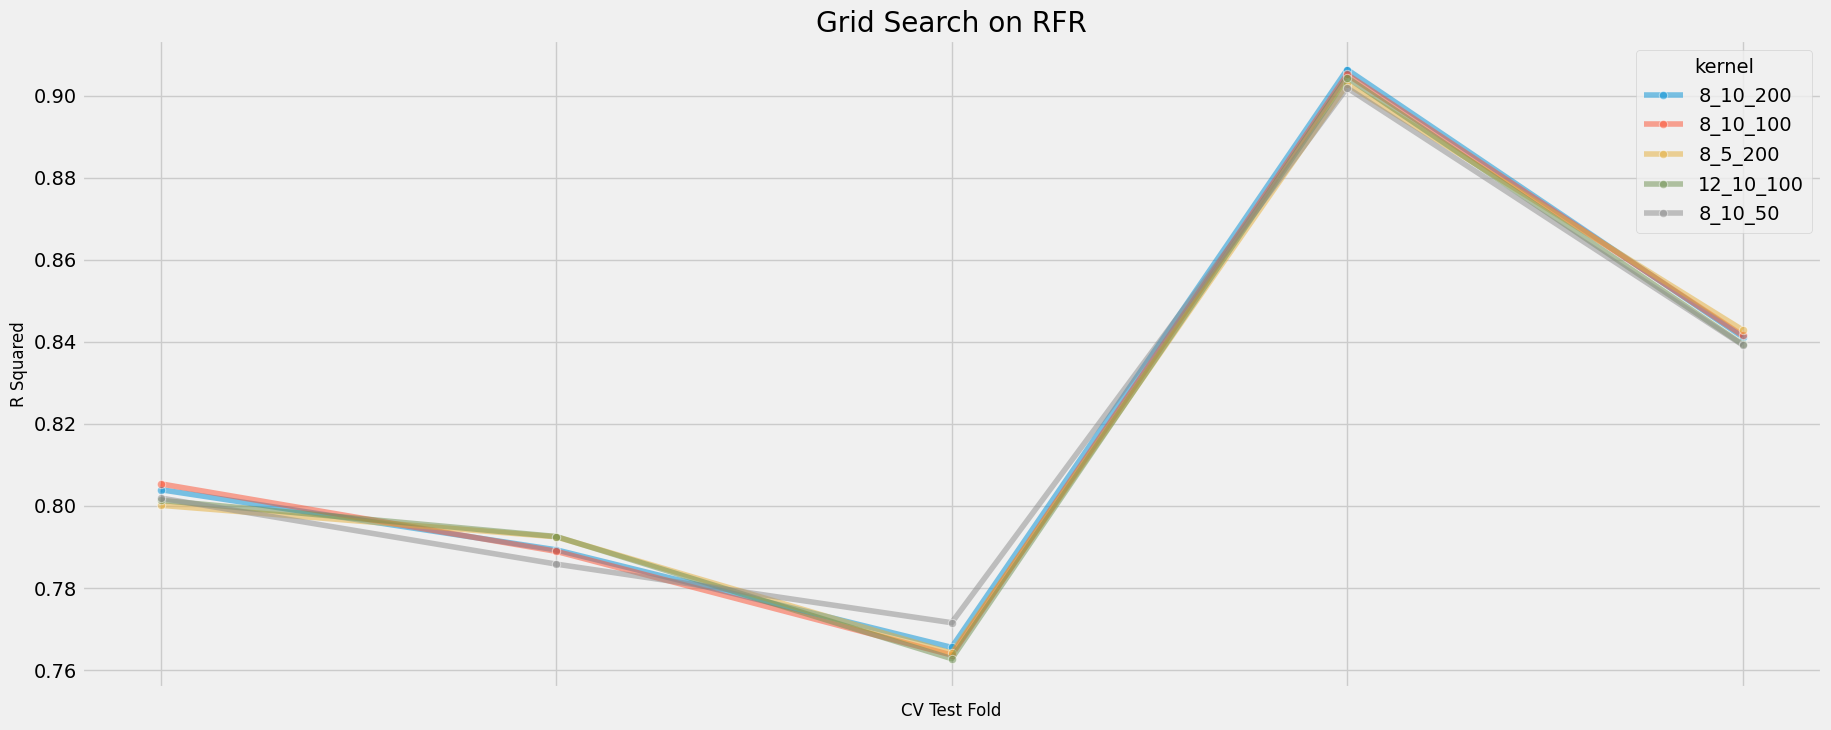

In [105]:
# Plotting top 5 performance for RFR model
rfr_results = top5_performance_plot(rfr_results,"CV Test Fold","R Squared","Grid Search on RFR")

In [106]:
# Training , predicting and evaluationg the best RFR model
predict_and_evaluate(best_model_rfr,X_train,y_train,X_test,y_test)

The Mean Absolute Error is : 1944.52
The Mean Square Error is  : 17381688.44
The Root Mean Square Error is : : 4169.14
The R squared score is : 0.89


## Support Vector Machine
Its architecture is more complex than linear regression, because it can be linear or non-linear depending on the chosen kernel function (e.g., linear kernel for linear regression-like behavior, non-linear kernels like RBF for capturing complex relationships).
> It focuses on finding a `hyperplane` (decision boundary) with the *maximum margin* between the data points and the margins (defined by a cost function).

In [107]:


# Defining the hyperparameter grid
param_grid_svr = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'epsilon': [0.001, 0.01, 0.1]
}

# Creating the SVR model
svr = SVR()

# Creating the GridSearchCV object
grid_search_svr,best_model_svr = grid_search(svr,param_grid_svr,"r2")

 Best parameters are : {'C': 1, 'epsilon': 0.1, 'kernel': 'rbf'} 


In [108]:
# getting performance table for SVR model
svr_results,svr_performance_table = performance_table(grid_search_svr)
svr_performance_table

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
1_0.1_rbf,"{'C': 1, 'epsilon': 0.1, 'kernel': 'rbf'}",1,0.818316,0.063915
1_0.01_rbf,"{'C': 1, 'epsilon': 0.01, 'kernel': 'rbf'}",2,0.815826,0.063435
1_0.001_rbf,"{'C': 1, 'epsilon': 0.001, 'kernel': 'rbf'}",3,0.815690,0.063453
10_0.01_rbf,"{'C': 10, 'epsilon': 0.01, 'kernel': 'rbf'}",4,0.814882,0.062901
10_0.1_rbf,"{'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}",5,0.814824,0.062319
10_0.001_rbf,"{'C': 10, 'epsilon': 0.001, 'kernel': 'rbf'}",6,0.814821,0.062894
0.1_0.001_rbf,"{'C': 0.1, 'epsilon': 0.001, 'kernel': 'rbf'}",7,0.793686,0.058138
0.1_0.01_rbf,"{'C': 0.1, 'epsilon': 0.01, 'kernel': 'rbf'}",8,0.793497,0.058139
0.1_0.1_rbf,"{'C': 0.1, 'epsilon': 0.1, 'kernel': 'rbf'}",9,0.791493,0.057780


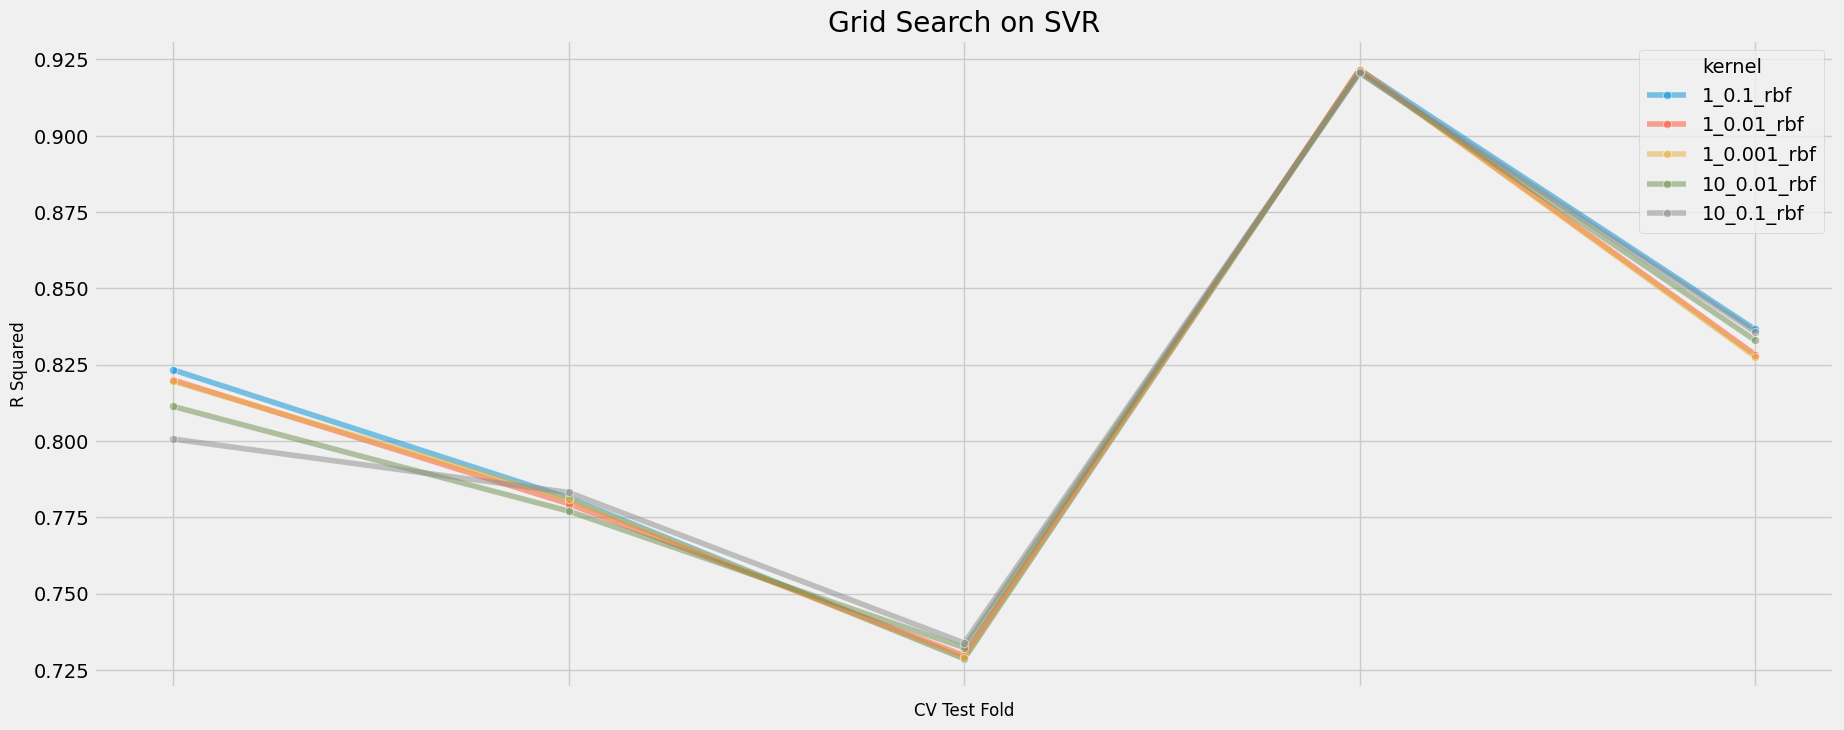

In [109]:
svr_results = top5_performance_plot(svr_results,"CV Test Fold","R Squared","Grid Search on SVR")

In [110]:
predict_and_evaluate(best_model_svr,X_train,y_train,X_test,y_test)

The Mean Absolute Error is : 2022.46
The Mean Square Error is  : 19200637.91
The Root Mean Square Error is : : 4381.85
The R squared score is : 0.88


## Multi-Layer Preceptron
Its architecture is Inspired by biological neural networks, consisting of an input layer, one or more hidden layers with activation functions (introduce non-linearity), and an output layer.

> It uses `backpropagation` algorithm to iteratively adjust the weights and biases in each layer to minimize the error between the predicted and actual target values.

In [111]:
# Initialising MLPR Model
mlpr = MLPRegressor()

# Defininf the parameter frid for MLPR model
param_grid_mlpr = {
    'hidden_layer_sizes': [(100,), (50, 50)],  # Grid of hidden layer configurations
    'solver': ['adam', 'lbfgs'],  # Grid of optimizers
    'alpha': np.logspace(-3, 2, 5)  # Grid of L2 regularization strength
}

# Creating the GridSearchCV object
grid_search_mlpr,best_model_mlpr = grid_search(mlpr,param_grid_mlpr,"r2")

 Best parameters are : {'alpha': 5.623413251903491, 'hidden_layer_sizes': (50, 50), 'solver': 'lbfgs'} 


In [112]:
# Returning Performance table (best 10)
mlpr_results,mlpr_performance_table = performance_table(grid_search_mlpr)
mlpr_performance_table

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
"5.623413251903491_(50, 50)_lbfgs","{'alpha': 5.623413251903491, 'hidden_layer_siz...",1,0.824757,0.051983
"5.623413251903491_(100,)_lbfgs","{'alpha': 5.623413251903491, 'hidden_layer_siz...",2,0.824342,0.051948
"0.31622776601683794_(100,)_lbfgs","{'alpha': 0.31622776601683794, 'hidden_layer_s...",3,0.800171,0.049459
"0.31622776601683794_(50, 50)_lbfgs","{'alpha': 0.31622776601683794, 'hidden_layer_s...",4,0.774862,0.053949
"0.01778279410038923_(50, 50)_adam","{'alpha': 0.01778279410038923, 'hidden_layer_s...",5,0.768874,0.064123
"0.001_(100,)_lbfgs","{'alpha': 0.001, 'hidden_layer_sizes': (100,),...",6,0.766087,0.044838
"0.001_(50, 50)_lbfgs","{'alpha': 0.001, 'hidden_layer_sizes': (50, 50...",7,0.765069,0.046016
"0.31622776601683794_(50, 50)_adam","{'alpha': 0.31622776601683794, 'hidden_layer_s...",8,0.764912,0.072219
"0.01778279410038923_(100,)_lbfgs","{'alpha': 0.01778279410038923, 'hidden_layer_s...",9,0.764053,0.042599


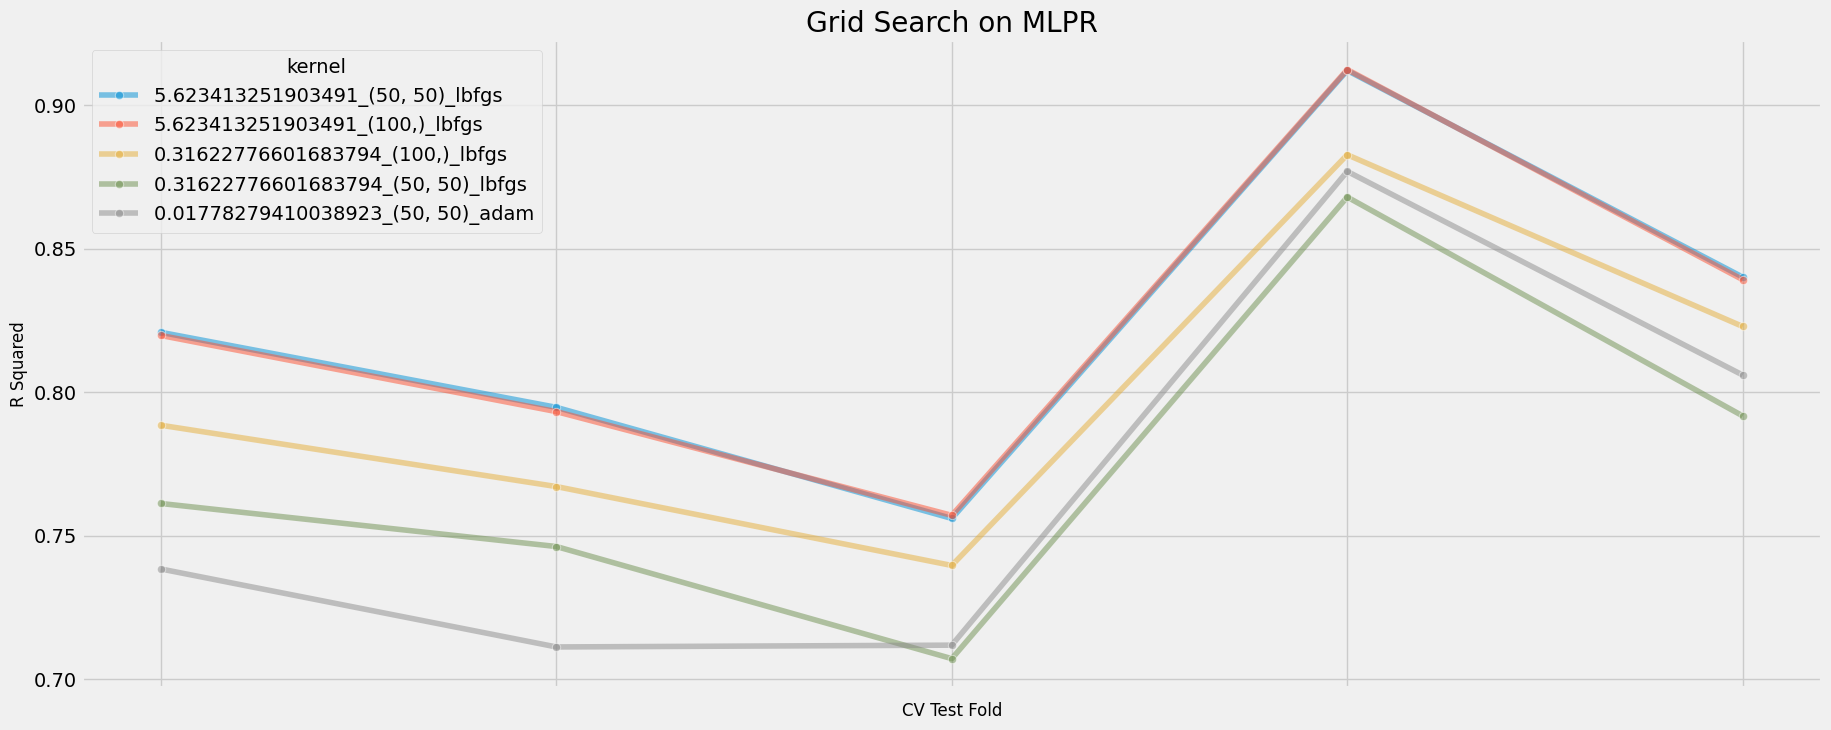

In [113]:
# Plotting Top 5 performing MLPR Models
mlpr_results = top5_performance_plot(mlpr_results,"CV Test Fold","R Squared","Grid Search on MLPR")

In [114]:
# Training , predicting and evaluationg best MLPR model
predict_and_evaluate(best_model_mlpr,X_train,y_train,X_test,y_test)

The Mean Absolute Error is : 2378.02
The Mean Square Error is  : 20481637.93
The Root Mean Square Error is : : 4525.66
The R squared score is : 0.87


# VI - Comparision :
Here is a simple comparisn of the best performing version of the different last 3 models RFR, SVR and MLPR

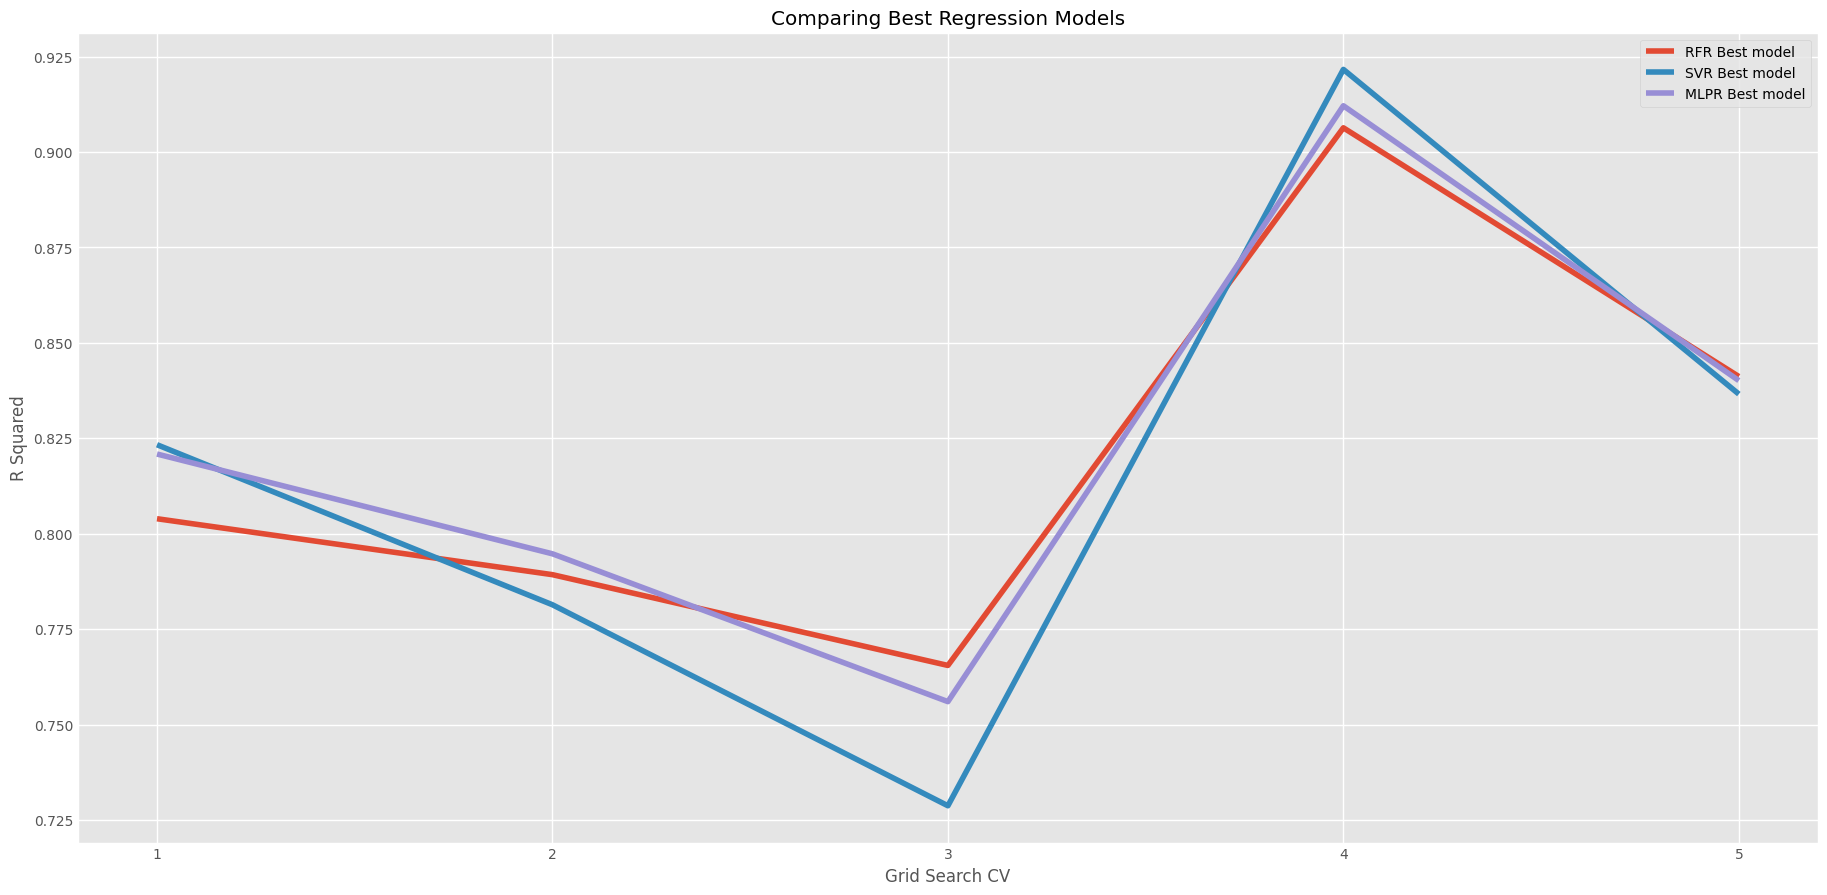

In [115]:
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
plt.plot(rfr_results.iloc[0].transpose(),label="RFR Best model")
plt.plot(svr_results.iloc[0].transpose(),label="SVR Best model")
plt.plot(mlpr_results.iloc[0].transpose(),label="MLPR Best model")
plt.title("Comparing Best Regression Models")
plt.xlabel("Grid Search CV")
plt.ylabel("R Squared")
plt.xticks(ticks= rfr_results.iloc[0].transpose().index ,labels=[1,2,3,4,5])
plt.legend();